# Classification with complex features

This exercise asks you to revisit the work we did in chapters 4 (vectorization) and 5 (classification) in light of what we've learned in chapter 7 (context-aware features).

## The task

Your task is to implement a working version of the stub code provided on pp. 77-78 of the textbook, then to compare the classification accuracy of such a system to the output of the token-only pipeline you built in [problem set 5](https://github.com/wilkens-teaching/textmining/blob/master/exercises/05%20classification%20answers.ipynb).

## More info
Note that you do not necessarily need to use the textbook code as supplied. Specifically, NLTK entity recognition as implemented in the stock `EntityExtractor` class is slow. This makes it hard to iterate over multiple classifiers or to perform grid search for parameter optimization. There are two ways to get around this:

* Use a faster NER system (like SpaCy)
* Break entity recognition out of your pipeline, so that you only need to perform it once. Then feed your extracted entity data into the pipeline. This option removes the ability to reproduce the full pipeline from raw input, but is analagous to the way in which we've been using the pre-tagged, pickled version of the corpus as our starting point.

Note that you are **not** required to do anything beyond the simplest version of the code presented on pp. 77-78. Any other optimizations, tweaks, comparisons between classifiers, etc. is strictly optional.

## Starter code

In [1]:
%matplotlib inline
# Imports and variables

import en_core_web_sm
import glob
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
import spacy
import sys
import tabulate
import time
import unicodedata
import warnings

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

# Import our corpus readers
sys.path.append(os.path.join('..', 'libraries'))
import TMN

# File locations
pkl_dir = os.path.join('..', 'data', 'pickled')
wordlist_dir = os.path.join('..', 'data', 'wordlists')

# Plotting settings
plt.rcParams['figure.figsize'] = [12, 8]

# Get stop- and offensive-word lists
def get_wordlists_from_files(wordlist_dir):
    """Read stopwords and offensive terms from files in wordlist_dir, return a set for each"""
    stopwords = []
    offensive = []
    stopword_files = glob.glob(wordlist_dir+'/stop*.txt')
    offensive_files = glob.glob(wordlist_dir+'/offensive*.txt')
    for f in stopword_files:
        with open(f, 'r') as fh:
            for line in fh.readlines():
                line = line.strip()
                if line:
                    stopwords.append(line)
    for f in offensive_files:
        with open(f, 'r') as fh:
            for line in fh.readlines():
                line = line.strip()
                if line:
                    offensive.append(line)
    return set(stopwords), set(offensive)

# stopwords to filter from corpus
STOPWORDS, OFFENSIVE = get_wordlists_from_files(wordlist_dir)
STOPWORDS = set(nltk.corpus.stopwords.words('english')).union(STOPWORDS)

## Stub code

Below is stub code from the textbook. You'll need, at the very least, to replace `HTMLParser` with a text normalizer like the ones we've seen repeatedly in recent chapters and to include the working `EntityExtractor()` and `KeyphraseExtractor` classes from chapter 7 (cf. notebook 7). You'll also need to incorporate this whole model into a cross-validation system like the one we built in problem set 5.

In [ ]:
# Stub code
model = Pipeline([
    ('parser', HTMLParser()),
    ('text_union', FeatureUnion(
        transformer_list = [
            ('entity_feature', Pipeline([
                ('entity_extractor', EntityExtractor()),
                ('entity_vect', CountVectorizer()),
            ])),
            ('keyphrase_feature', Pipeline([
                ('keyphrase_extractor', KeyphraseExtractor()),
                ('keyphrase_vect', TfidfVectorizer()),
            ])),
        ],
        transformer_weights= {
            'entity_feature': 0.6,
            'keyphrase_feature': 0.2,
        }
    )),
    ('clf', LogisticRegression()),
])

In [62]:
# Classification system
def identity(words):
    return words


def mask_offensive(token):
    """Make lemmatized offensive words less objectionable for display"""
    if token in OFFENSIVE:
        return token[0]+(len(token)-3)*'*'+token[-2:]
    else:
        return token

    
def create_pipeline(estimator=LogisticRegression, reduction=False):

    steps = [
        ('text_union', FeatureUnion(
            transformer_list = [
                ('entity_feature', Pipeline([
                    ('entity_extractor', EntityExtractor()),
                    ('entity_vect', CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
                ])),
                ('keyphrase_feature', Pipeline([
                    ('keyphrase_extractor', TMN.KeyphraseExtractor()),
                    ('keyphrase_vect', TfidfVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)),
                ])),
            ],
            transformer_weights= {
                'entity_feature': 0.6,
                'keyphrase_feature': 0.2,
            }
        )),
        ('classifier', estimator()),
    ]

    return Pipeline(steps)


def score_models(models, loader):
    for model in models:

        name = model.named_steps['classifier'].__class__.__name__
        if 'reduction' in model.named_steps:
            name += ' (' + model.named_steps['reduction'].__class__.__name__ + ')'
        print(name, '::', time.ctime())

        scores = {
            'model': str(model),
            'name': name,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'time': [],
        }

        for X_train, X_test, y_train, y_test in loader:
            start = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scores['time'].append(time.time() - start)
            scores['accuracy'].append(accuracy_score(y_test, y_pred))
            scores['precision'].append(precision_score(y_test, y_pred, average='weighted'))
            scores['recall'].append(recall_score(y_test, y_pred, average='weighted'))
            scores['f1'].append(f1_score(y_test, y_pred, average='weighted'))

        yield scores
        
def tabulate_scores(scores):
    import tabulate

    fields = ['model', 'time', 'precision', 'recall', 'accuracy', 'f1']
    table = []

    for score in scores:
        row = [score['name']]
        for field in fields[1:]:
            row.append("{:0.3f}".format(np.mean(score[field])))
        table.append(row)

    table.sort(key=lambda r: r[-1], reverse=True)
    print(tabulate.tabulate(table, headers=fields))
    

class EntityExtractor(BaseEstimator, TransformerMixin):
    #def __init__(self, **kwargs):
        #self.nlp = en_core_web_sm.load()
        
    def get_entities(self, document):
        nlp = en_core_web_sm.load()
        entities = []
        for paragraph in document[0]:
            text = ''
            for sentence in paragraph:
                for token in sentence:
                    text+= token[0]+' '
            doc = nlp(text)
            for ent in doc.ents:
                entities.append(ent.text)

        return entities

    def fit(self, documents, labels=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.get_entities(document)

In [57]:
%%time
e = EntityExtractor()
corpus = TMN.PickledCorpusReader(pkl_dir)
ents = e.transform(corpus.docs())
ents = [list(i) for i in ents]

CPU times: user 1h 8s, sys: 4min 22s, total: 1h 4min 31s
Wall time: 33min 33s


In [58]:
vectorizer = CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)

vecs = vectorizer.fit_transform(ents)
print(vecs.shape)

(40, 25481)


## Base system output

In [65]:
%%time 
labels = ['A', 'B']
corpus = TMN.PickledCorpusReader(pkl_dir)
loader = TMN.CorpusLoader(corpus, 4, shuffle=True, categories=labels)

models = [create_pipeline()]

tabulate_scores(score_models(models, loader))

LogisticRegression :: Thu Apr  4 23:17:41 2019


ValueError: empty vocabulary; perhaps the documents only contain stop words

In [74]:
%%time
mod = create_pipeline()
labels = [corpus.categories(fileids=fileid)[0] for fileid in corpus.fileids(categories=['A', 'B'])]
mod.fit(corpus.docs(), labels)

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 39, expected 1.

In [30]:
y_pred = mod.predict(corpus.docs())

print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

NotFittedError: TfidfVectorizer - Vocabulary wasn't fitted.

In [16]:
doc = [['The', 'first', 'doc'], ['The', 'second', 'doc']]
vec = CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False)
out = vec.fit_transform(doc)

In [19]:
vec.get_feature_names()

['The', 'doc', 'first', 'second']

In [20]:
out.todense()

matrix([[1, 1, 1, 0],
        [1, 1, 0, 1]], dtype=int64)

## Evaluate a bunch of classifiers

Back to non-chunked data, but continue using pre-computed normalized texts and PCA dimension-reduction.

AdaBoostClassifier (PCA) :: Mon Mar 11 21:09:27 2019
BernoulliNB (PCA) :: Mon Mar 11 21:11:20 2019
DecisionTreeClassifier (PCA) :: Mon Mar 11 21:13:07 2019
GaussianNB (PCA) :: Mon Mar 11 21:14:56 2019
GaussianProcessClassifier (PCA) :: Mon Mar 11 21:16:35 2019
KNeighborsClassifier (PCA) :: Mon Mar 11 21:17:58 2019
LinearSVC (PCA) :: Mon Mar 11 21:19:26 2019
LogisticRegression (PCA) :: Mon Mar 11 21:20:53 2019
MLPClassifier (PCA) :: Mon Mar 11 21:22:19 2019
NearestCentroid (PCA) :: Mon Mar 11 21:23:43 2019
PassiveAggressiveClassifier (PCA) :: Mon Mar 11 21:25:08 2019
Perceptron (PCA) :: Mon Mar 11 21:26:32 2019
QuadraticDiscriminantAnalysis (PCA) :: Mon Mar 11 21:28:00 2019
RandomForestClassifier (PCA) :: Mon Mar 11 21:29:30 2019
RidgeClassifier (PCA) :: Mon Mar 11 21:30:59 2019
SGDClassifier (PCA) :: Mon Mar 11 21:32:29 2019
SVC (PCA) :: Mon Mar 11 21:33:59 2019


,f1_mean,f1_std
name,,
SGDClassifier (PCA),0.866667,0.221108
Perceptron (PCA),0.866667,0.266667
GaussianNB (PCA),0.833333,0.247207
RidgeClassifier (PCA),0.800000,0.244949
LinearSVC (PCA),0.783333,0.242097
PassiveAggressiveClassifier (PCA),0.766667,0.366667
SVC (PCA),0.733333,0.359011
NearestCentroid (PCA),0.733333,0.290593
MLPClassifier (PCA),0.733333,0.343188


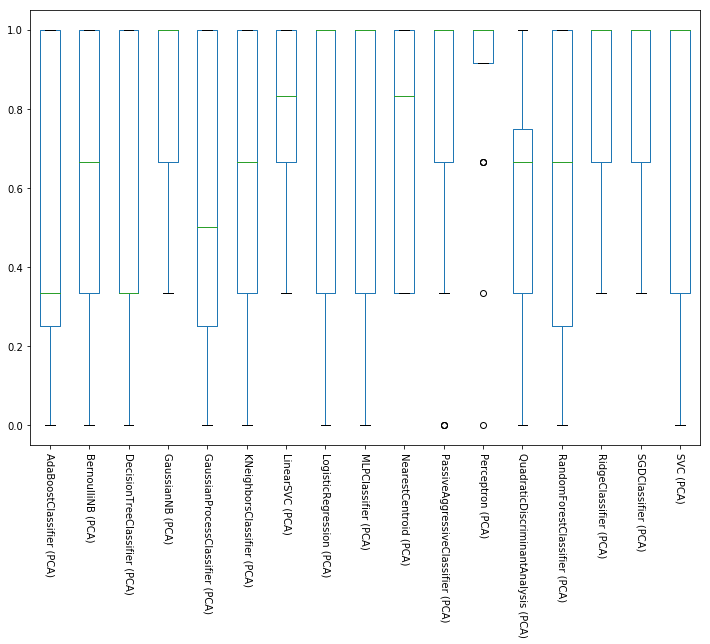

CPU times: user 26min 35s, sys: 47.2 s, total: 27min 22s
Wall time: 26min 5s


In [97]:
%%time
labels = ['A', 'B']
corpus = TMN.PickledCorpusReader(pkl_nrm_dir)
loader = CorpusLoader(corpus, 20, shuffle=True, categories=labels)

def classifier_compare(scores):
    """
    Take output from score_models().
    Tabulate and plot performance.
    """
    df = pd.DataFrame.from_dict(scores)
    pd.DataFrame(
        df['f1'].values.tolist(), 
        index=df.name
    ).T.plot.box(
        figsize=(12,8), 
        rot=-90, 
        sort_columns=True
    )
    df.set_index('name', inplace=True)
    df['f1_mean'] = df.f1.apply(lambda x: np.mean(np.asarray(x)))
    df['f1_std']  = df.f1.apply(lambda x: np.std(np.asarray(x)))
    display(df[['f1_mean', 'f1_std']].sort_values(by='f1_mean', ascending=False))
    plt.show()
    
# redefine create_pipeline with different vectorization settings
def create_pipeline(estimator, reduction=False):

    steps = [
        ('normalize', TextNormalizerPre()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False,
            min_df=2, max_df=0.5, binary=True
        )),
        ('make_dense', DenseTransformer())
    ]

    if reduction:
        steps.append((
            'reduction', PCA()
        ))

    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)


models = []
models.append(create_pipeline(AdaBoostClassifier(), True))
models.append(create_pipeline(BernoulliNB(), True))
models.append(create_pipeline(DecisionTreeClassifier(max_depth=5), True))
models.append(create_pipeline(GaussianNB(), True))
models.append(create_pipeline(GaussianProcessClassifier(1.0 * RBF(1.0)), True))
models.append(create_pipeline(KNeighborsClassifier(), True))
models.append(create_pipeline(LinearSVC(), True))
models.append(create_pipeline(LogisticRegression(solver='liblinear'), True))
models.append(create_pipeline(MLPClassifier(alpha=1), True))
models.append(create_pipeline(NearestCentroid(), True))
models.append(create_pipeline(PassiveAggressiveClassifier(max_iter=1000, tol=1e-3), True))
models.append(create_pipeline(Perceptron(max_iter=1000, tol=1e-3), True))
models.append(create_pipeline(QuadraticDiscriminantAnalysis(), True))
models.append(create_pipeline(RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), True))
models.append(create_pipeline(RidgeClassifier(tol=1e-2, solver="lsqr"), True))
models.append(create_pipeline(SGDClassifier(max_iter=1000, tol=1e-3), True))
models.append(create_pipeline(SVC(gamma=2, C=1), True))
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    classifier_compare(score_models(models, loader))

## Same comparison for F/M classes

AdaBoostClassifier (PCA) :: Mon Mar 11 21:35:31 2019
BernoulliNB (PCA) :: Mon Mar 11 21:37:03 2019
DecisionTreeClassifier (PCA) :: Mon Mar 11 21:38:35 2019
GaussianNB (PCA) :: Mon Mar 11 21:40:07 2019
GaussianProcessClassifier (PCA) :: Mon Mar 11 21:41:39 2019
KNeighborsClassifier (PCA) :: Mon Mar 11 21:43:13 2019
LinearSVC (PCA) :: Mon Mar 11 21:44:45 2019
LogisticRegression (PCA) :: Mon Mar 11 21:46:17 2019
MLPClassifier (PCA) :: Mon Mar 11 21:47:49 2019
NearestCentroid (PCA) :: Mon Mar 11 21:49:22 2019
PassiveAggressiveClassifier (PCA) :: Mon Mar 11 21:50:54 2019
Perceptron (PCA) :: Mon Mar 11 21:52:25 2019
QuadraticDiscriminantAnalysis (PCA) :: Mon Mar 11 21:53:57 2019
RandomForestClassifier (PCA) :: Mon Mar 11 21:55:30 2019
RidgeClassifier (PCA) :: Mon Mar 11 21:57:01 2019
SGDClassifier (PCA) :: Mon Mar 11 21:58:37 2019
SVC (PCA) :: Mon Mar 11 22:00:08 2019


,f1_mean,f1_std
name,,
Perceptron (PCA),0.850000,0.288194
GaussianNB (PCA),0.833333,0.288675
NearestCentroid (PCA),0.800000,0.266667
MLPClassifier (PCA),0.783333,0.303223
RidgeClassifier (PCA),0.783333,0.264050
LinearSVC (PCA),0.783333,0.264050
PassiveAggressiveClassifier (PCA),0.750000,0.347611
SGDClassifier (PCA),0.750000,0.347611
SVC (PCA),0.716667,0.242097


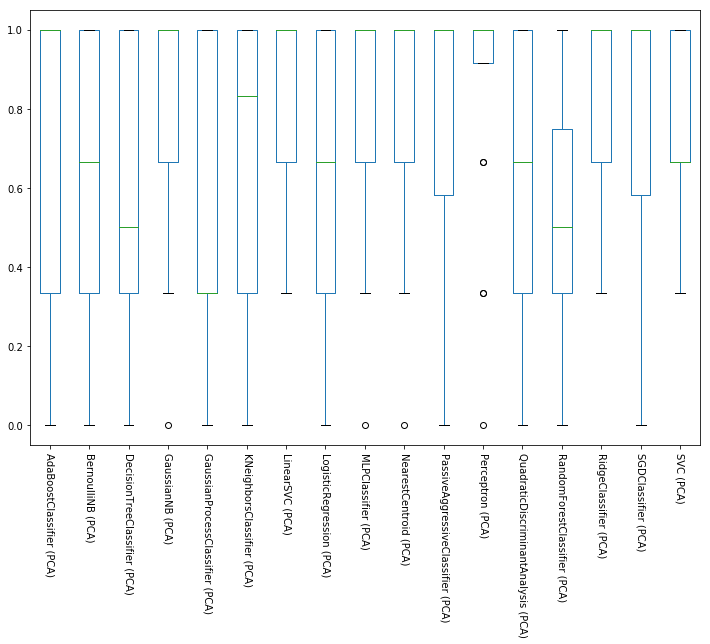

CPU times: user 27min 24s, sys: 42 s, total: 28min 6s
Wall time: 26min 9s


In [98]:
%%time
labels = ['F', 'M']
loader = CorpusLoader(corpus, 20, shuffle=True, categories=labels)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    classifier_compare(score_models(models, loader))

## To try

We've only scratched the surface here. Obvious things to try:

* Standard scaling of features (mean 0, standard deviation 1)
* Other classifiers
* Parameter optimization (note how much better GaussianNB did with different vectorization settings)
* Feature engineering
* More data
* Chunking with test/train splits that respect text boundaries
* Grid search
* ...?